# Rendering meshes

In this tutorial, we will go through details of mesh rendering with DRTK

## Imports

In [1]:
import cv2
import imageio
import numpy as np
import torch as th
from care.data.io import typed
import drtk
from PIL import Image
from torch.nn import functional as thf
import igl

I1002 171307.708 _utils_internal.py:314] NCCL_DEBUG env var is set to None


I1002 171307.711 _utils_internal.py:323] NCCL_DEBUG is INFO from /etc/nccl.conf


## Setup scene

In [2]:
image_height, image_width = 1024, 1024

camera_distance = 0.5
a1 = np.pi
a2 = 1
a3 = 0
offset = np.array([0, 0.1, 0])

# Let's say we have only v and vi
v, vt, _, vi, vti, _ = igl.read_obj("bunny.obj")
v = th.tensor(v, dtype=th.float32)[None, ...].cuda()
vi = th.tensor(vi, dtype=th.int32).cuda()
vt = th.tensor(vt, dtype=th.float32).cuda()
vti = th.tensor(vti, dtype=th.int32).cuda()

def rodrigues(x):
    x, _ = cv2.Rodrigues(np.asarray(x, dtype=np.float64))
    return np.float64(x)

# camera extrinsics
t = np.array([0, 0, camera_distance], dtype=np.float64)
R = np.matmul(np.matmul(rodrigues([a1, 0, 0]), rodrigues([0, a2, 0])), rodrigues([0, 0, a3]))
cam_pos = th.as_tensor((R.transpose(-1, -2) @ -t[..., None])[..., 0] + offset, dtype=th.float32).cuda()[None]
cam_rot = th.as_tensor(R, dtype=th.float32).cuda()[None]

# camera intrinsics
focal = th.as_tensor([[2 * image_width, 0.0], [0.0, 2 * image_height]], dtype=th.float32).cuda()[None]
princpt = th.as_tensor(
    [image_width / 2, image_height / 2],
    dtype=th.float32,
).cuda()[None]

## Compute mesh normals

In [3]:
def face_normals(
    v: th.Tensor, vi: th.Tensor, normalize: bool = True, eps: float = 1e-8
):
    B = v.shape[0]
    NF = vi.shape[0]
    p = th.index_select(
        v,
        dim=1,
        index=vi.view(
            -1,
        ),
    ).view(B, NF, 3, 3)
    fn = th.linalg.cross(p[:, :, 0] - p[:, :, 2], p[:, :, 1] - p[:, :, 0], dim=-1)
    if normalize:
        fn = thf.normalize(fn, dim=-1, eps=eps)
    return fn


def face_attribute_to_vert(v: th.Tensor, vi: th.Tensor, attr: th.Tensor) -> th.Tensor:
    attr = (
        attr[:, :, None]
        .expand(-1, -1, 3, -1)
        .reshape(attr.shape[0], -1, attr.shape[-1])
    )
    vi_flat = vi.view(vi.shape[0], -1).expand(v.shape[0], -1)
    vattr = th.zeros(v.shape[:-1], dtype=v.dtype, device=v.device)

    vattr = th.stack(
        [vattr.scatter_add(1, vi_flat, attr[..., i]) for i in range(attr.shape[-1])],
        dim=-1,
    )
    return vattr


def vert_normals(
    v: th.Tensor, vi: th.Tensor, normalize: bool = True, eps: float = 1e-8
):
    assert vi.dtype == th.int64
    # NOTE: we do not need to normalize face normals prior to re-sampling
    fn = face_normals(v, vi, normalize=False)
    vn = face_attribute_to_vert(v, vi[np.newaxis], fn)
    if normalize:
        vn = thf.normalize(vn, dim=-1, eps=eps)
    return vn


# compute screen-space normals
av3d = (cam_rot[:, None] @ (v - cam_pos[:, None])[..., None])[..., 0]
normals = -vert_normals(av3d, vi.long())

## Rendering

In [4]:
# convert verteices positions to image space
v_pix = drtk.transform(v, cam_pos, cam_rot, focal, princpt)

# rasterize. This operation is not differentiable. You would need to use edge_grad_estimator
index_img = drtk.rasterize(v_pix, vi, image_height, image_width)

# compute mesh mask. We add an additional dimention, to make it easily comatible with other BxCxHxW tensors
mask = (index_img != -1)[:, None]

# compute differentiable depth and barycentric coordinates
depth_img, bary_img = drtk.render(v_pix, vi, index_img)

# interpolate normals in image space
vn_img = drtk.interpolate(normals, vi, index_img, bary_img)

# interpolate uv coordinates in image space. Notice that vti is used and not vi
vt_img = drtk.interpolate(vt.expand(v.shape[0], -1, -1), vti, index_img, bary_img)

## Display results

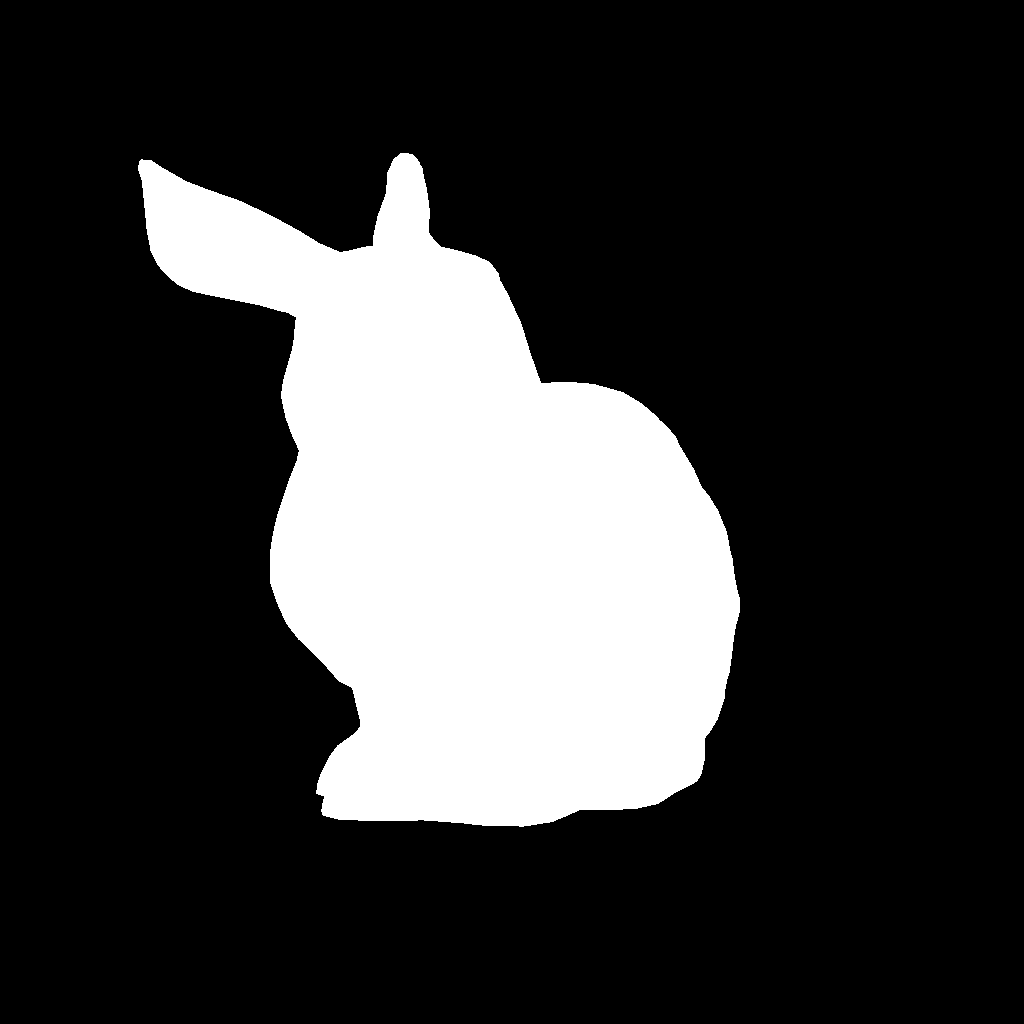

In [5]:
# Display mask
Image.fromarray(mask[0, 0].float().mul(255).clamp(0, 255).byte().cpu().numpy())

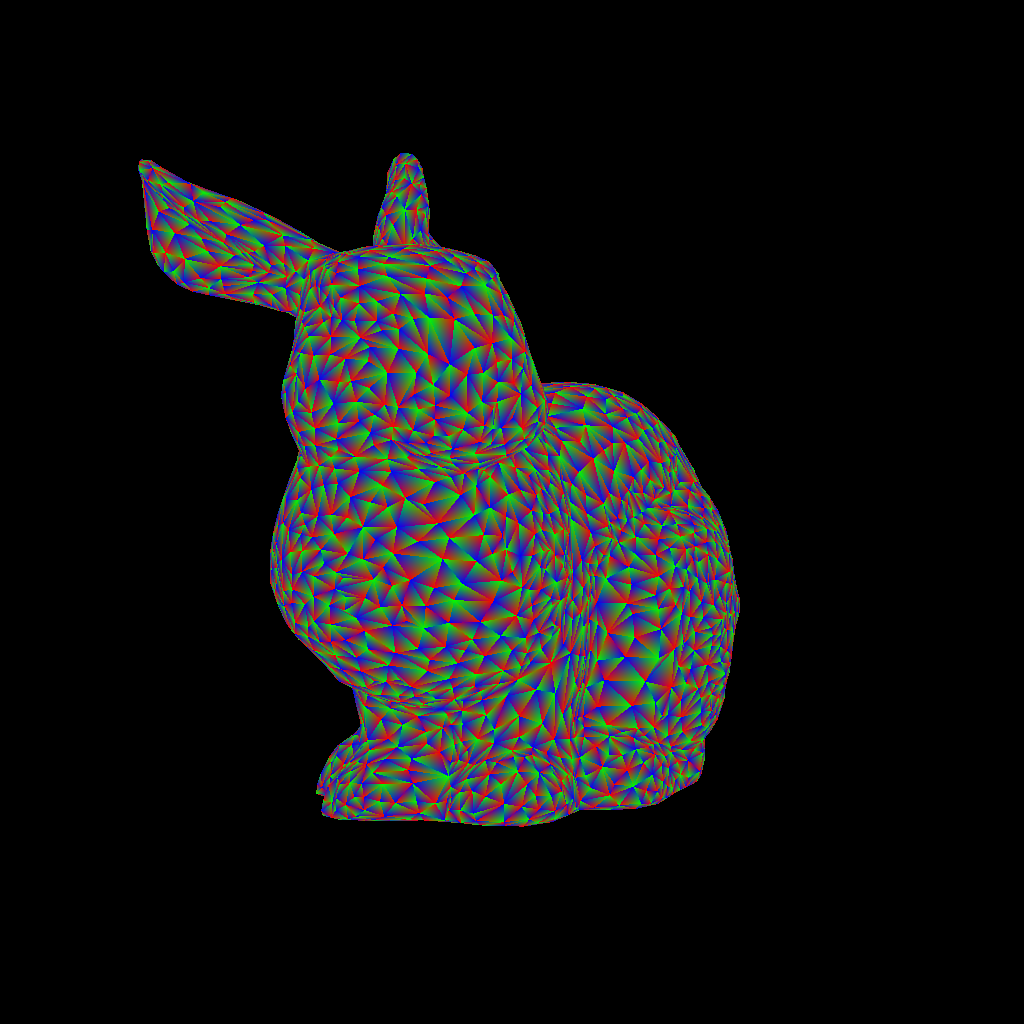

In [6]:
# Display bary_img
Image.fromarray(bary_img[0].permute(1, 2, 0).float().mul(255).clamp(0, 255).byte().cpu().numpy())

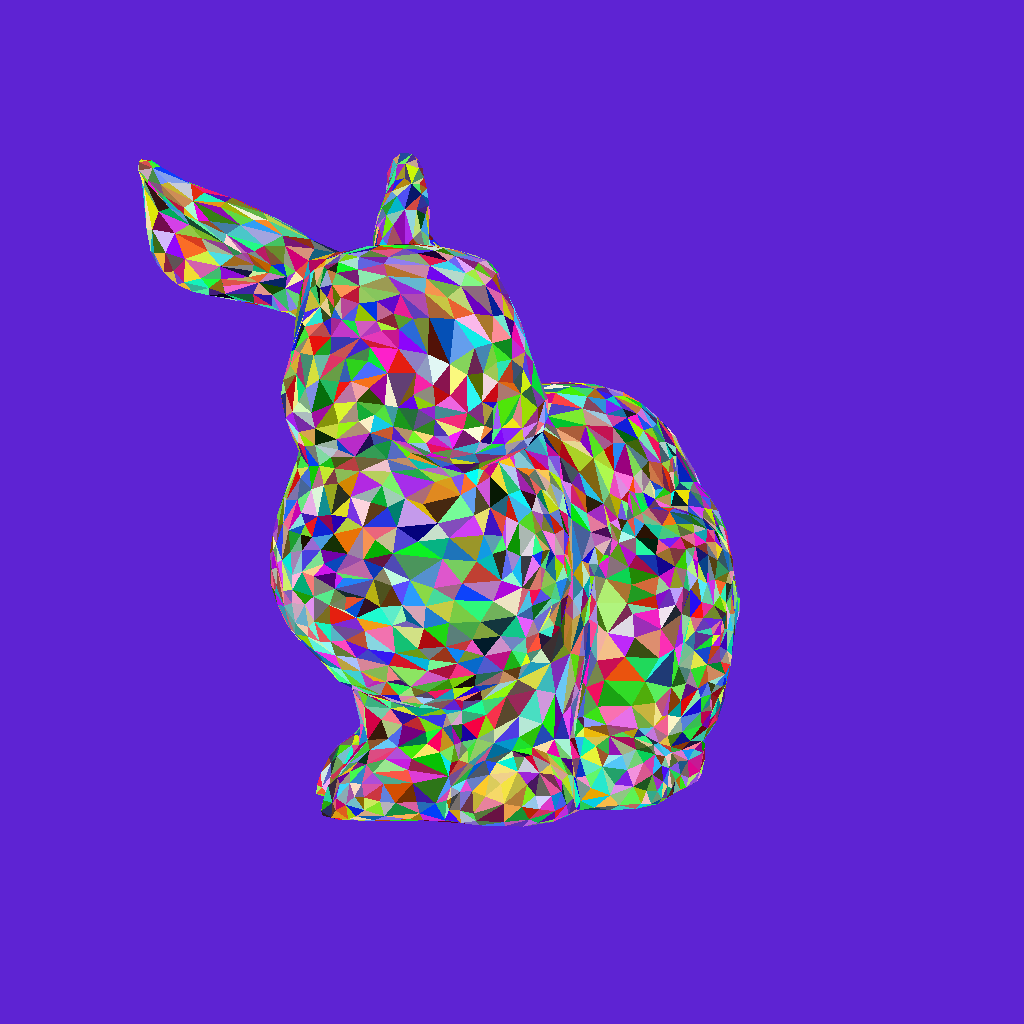

In [7]:
# Display index_img
colors = th.rand([index_img.amax() + 1, 3]).cuda()
index_img_colored = colors[index_img.long(), :]
Image.fromarray(index_img_colored[0].float().mul(255).clamp(0, 255).byte().cpu().numpy())

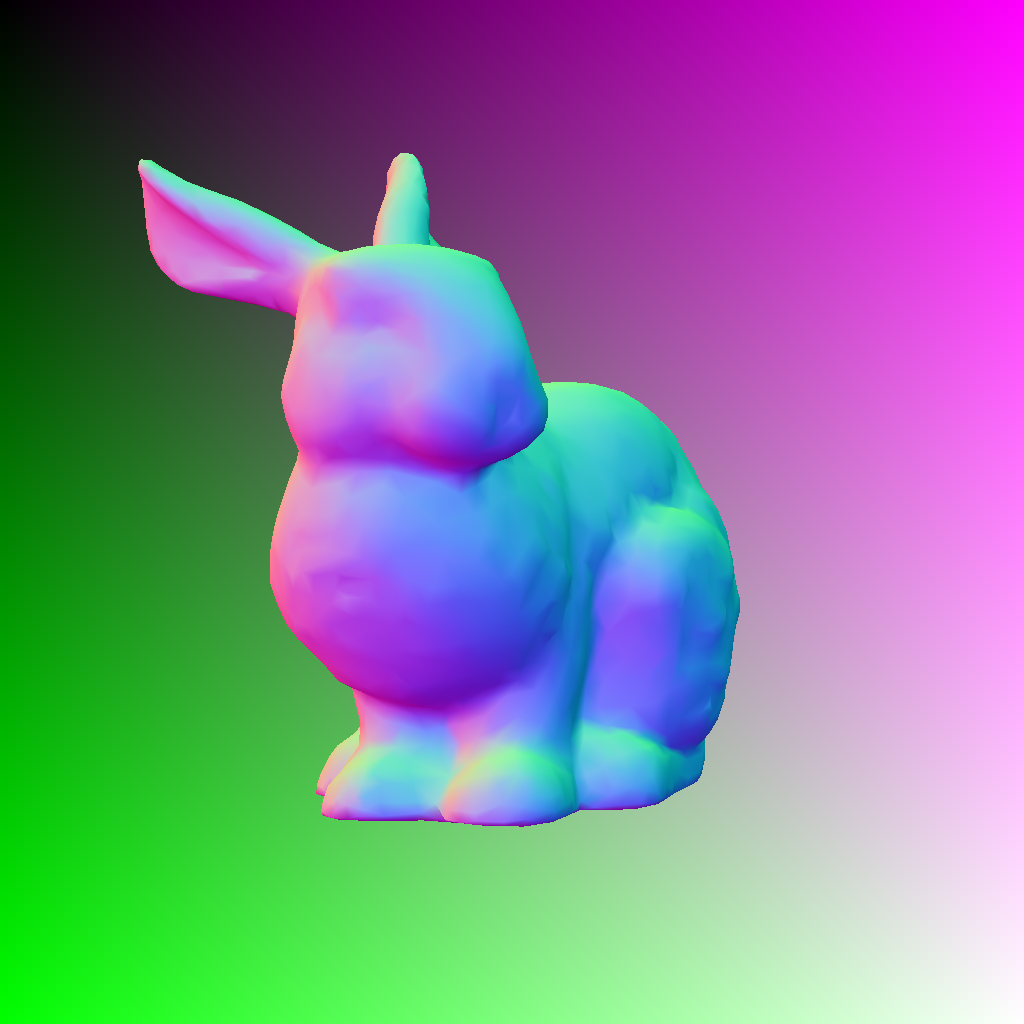

In [8]:
# Display vn_img
Image.fromarray((vn_img.permute(0, 2, 3, 1)[0] * 0.5 + 0.5).float().mul(255).clamp(0, 255).byte().cpu().numpy())

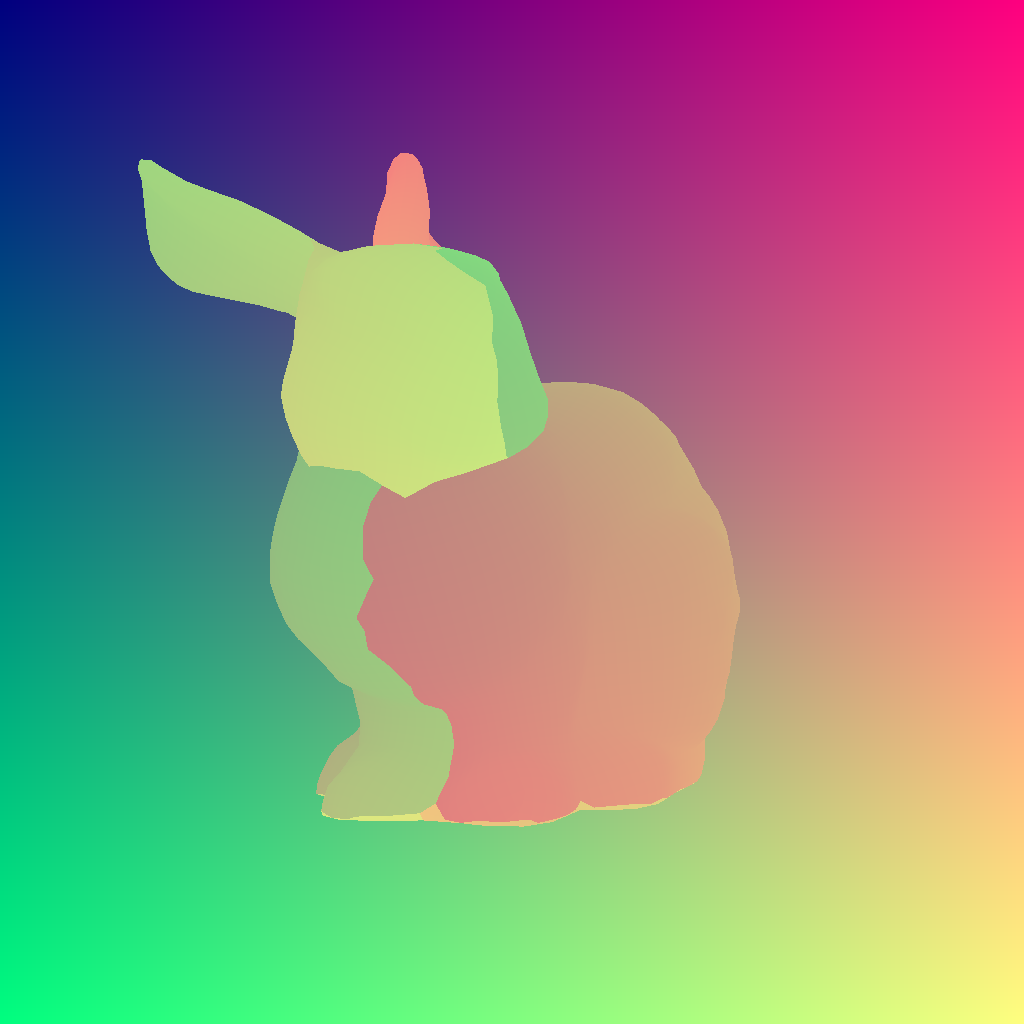

In [9]:
# Display uv_img
Image.fromarray((th.cat([vt_img, th.zeros_like(vt_img[:, :1])], dim=1).permute(0, 2, 3, 1)[0] * 0.5 + 0.5).float().mul(255).clamp(0, 255).byte().cpu().numpy())

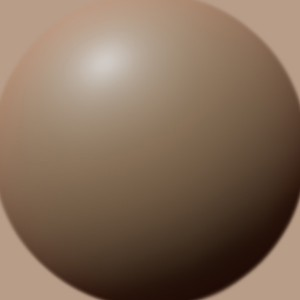

In [10]:
# using matcap
matcap = imageio.imread("matcap.png")
display(Image.fromarray(matcap))
matcap = th.as_tensor(matcap, dtype=th.uint8).permute(2, 0, 1)[None, ...].cuda().float() / 255.0
matcap = matcap[:, :3]

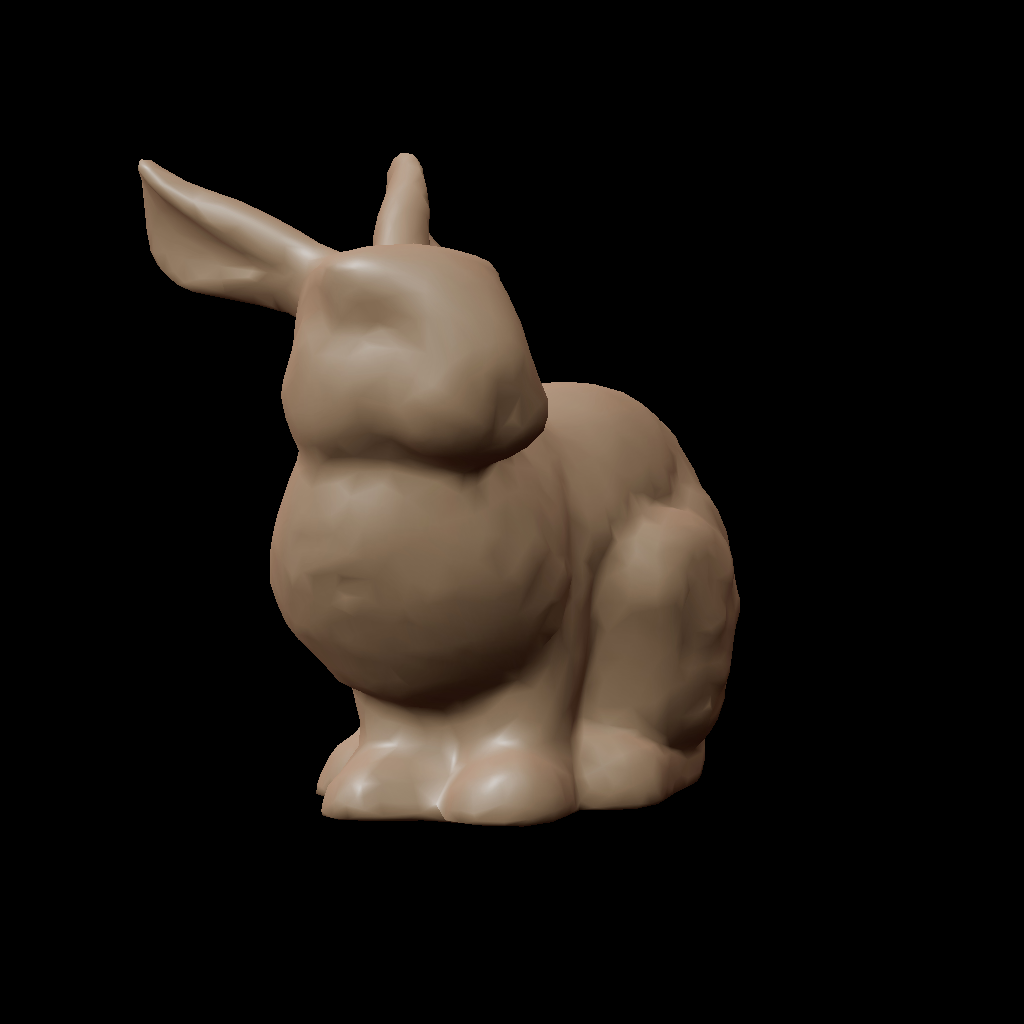

In [11]:
matcap_size = matcap.shape[-1]
mesh_image = (
    thf.grid_sample(
        matcap, ((-vn_img.permute(0, 2, 3, 1)[..., :2] * (matcap_size - 1.0) / matcap_size + 0.5 / matcap_size)), padding_mode="border"
    )
    * mask
)
Image.fromarray((mesh_image[0].permute(1, 2, 0)).float().mul(255).clamp(0, 255).byte().cpu().numpy())